In [1]:
from mplsoccer import Pitch, VerticalPitch
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt 
import math
import sqlite3
from adjustText import adjust_text
from difflib import SequenceMatcher
import os
from sklearn.cluster import KMeans
import unidecode
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
query = """
SELECT
  TeamId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
FROM(
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.EPL_2022` UNION ALL
    SELECT
  TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Bundesliga_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.La_Liga_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Ligue_1_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Serie_A_2022`
  ) as data
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players ON data.PlayerId = players.id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Teams` as teams ON data.TeamId = teams.id
WHERE
  Type = 'Pass'
  AND OutcomeType = TRUE
  AND PassEndX >= 83
  AND PassEndY <= 79
  AND PassEndY >= 21
"""
df = pd.read_gbq(query)
df = df[(df['X']<83) | (df['Y'] > 79) | (df['Y'] < 21)]
to_remove = [5,10,20,35,47,62]
def remove_set_piece(row):
    tmp = np.in1d(to_remove,row['Qualifiers'])
    if True in tmp:
        return 
    else:
        return 1 #means not a set piece
def key_pass(row):
    keypass= [26,27] 
    tmp = np.in1d(keypass,row['Qualifiers'])
    if True in tmp:
        return 
    else:
        return 1

df['setpiece'] = df.apply(lambda x:remove_set_piece(x),axis=1)
df = df.dropna(subset='setpiece')

In [3]:
conn = sqlite3.connect(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\soccer_data.db")
league_df = pd.read_sql('SELECT Squad, Competition_Name FROM Squad_Data',conn).replace('Leicester City','Leicester')
df = df.merge(league_df,how='left',left_on='team',right_on='Squad') #get leagues

In [4]:
pl = df[df['Competition_Name'] =='Premier League']

In [5]:
def get_logo(clubs):
    logo_urls = []
    for club in clubs:
        #name = club.replace('FC','')
        name = unidecode.unidecode(club)
        BASE = r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\\"
        first = name.split()[0] 
        if os.path.exists(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{name}.png'):
            name = name + '.png'
            logo_urls.append(BASE+ name)
        elif os.path.exists(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{first}.png'):
            name = first + '.png'
            logo_urls.append(BASE + name)
        else: 
            print('Error ', club)
            print(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{name}.png')
    logo_urls.sort()
    return logo_urls

In [71]:
def plot_team(ax,team,pitchcolor,linecolor,leftcolor,rightcolor,edgecolor,pointcolor,logopath,textcolor):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20,pad_top=15,pitch_color=pitchcolor,line_color=linecolor)
    pitch.draw(ax=ax)
    def plot_arrows(X,ax,arrowcolor):
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        largest = X['cluster'].value_counts().index[0]
        tmp = X[X['cluster']==largest]
        # pitch.arrows(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,width=1.2,color=arrowcolor)
        pitch.lines(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,lw=1.2,color=arrowcolor)
        pitch.scatter(tmp['PassEndX'],tmp['PassEndY'],ax=ax,color=arrowcolor,s=20,linewidths=0)
        tmp = X[X['cluster']!=largest]
        # pitch.arrows(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,alpha=0.1,zorder=-1,width=1,color='#D1BE9C')
        pitch.lines(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,alpha=0.1,zorder=-1,lw=1,color='#D1BE9C')
        pitch.scatter(tmp['PassEndX'],tmp['PassEndY'],ax=ax,color='#D1BE9C',s=20,alpha=0.1,zorder=-1,linewidths=0)
        return ax 

    x1 = team[team['Y']>50]['Y'].mean()
    x2 = team[team['Y']<50]['Y'].mean()
    y1 = team[team['Y']>50]['X'].mean()
    y2 = team[team['Y']<50]['X'].mean()
    ax.scatter((x1,x2),(y1,y2),s=100,zorder=5,c=pointcolor)
    ax.plot((x1,x2),(y1,y2),zorder=4,linewidth=1.5,c=pointcolor,linestyle = '--')
    

    #text
    # dist = round(math.dist((x1,y1),(50,100)),1)
    ax.text(x1,y1-5,round(y1,1),ha='center',va='center',color='white',fontsize=12,font='Roboto',fontweight='black',bbox=dict(facecolor=pitchcolor,alpha=0,edgecolor='none',boxstyle='round4'))
    # dist = round(math.dist((x2,y2),(50,100)),1)
    ax.text(x2,y2-5,round(y2,1),ha='center',va='center',color='white',fontsize=12,font='Roboto',fontweight='black',bbox=dict(facecolor=pitchcolor,alpha=0,edgecolor='none',boxstyle='round4'))
    #fit both sides 
    X = team[team['Y'] > 50 ][['X','Y','PassEndX','PassEndY']]
    ax = plot_arrows(X,ax,rightcolor)
    X = team[team['Y'] < 50 ][['X','Y','PassEndX','PassEndY']]
    ax = plot_arrows(X,ax,leftcolor)

    #stats 
    team['keypass'] = team.apply(lambda x:key_pass(x),axis=1)
    kp = len(team[team['keypass'] == 1])
    kp_pct = round(kp/len(team)*100,1)
    ax.text(40,105.5,f'Key Passes: {kp} ({kp_pct}%)',ha='left',va='center',color=textcolor,font=font)
    top = team['Player'].value_counts().index[0]
    top_no = team['Player'].value_counts().iloc[0]
    ax.text(40,103,f'{top} ({top_no})',ha='left',va='center',color=textcolor,fontweight='black',font=font)
    mid = round(math.dist((x1,x2),(y1,y2)),1)
    ax.text(40,107,f'Width: {mid}',color=textcolor,ha='left',va='bottom',font=font)

    logoax = ax.inset_axes([0.14,0.82,0.18,0.18])
    im = plt.imread(logopath)
    logoax.imshow(im)
    logoax.axis('off')

    return ax


In [61]:
def plot_legend(ax,pitchcolor,linecolor,leftcolor,rightcolor,edgecolor,pointcolor,textcolor):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-68,pad_top=37,pitch_color=pitchcolor,line_color=linecolor)
    pitch.draw(ax=ax)
    ax.scatter(85,119,s=90,zorder=2,linewidths=1,edgecolors=edgecolor,c=pointcolor)
    # ax.text(85,120,'XX',ha='center',va='center',fontsize=8)
    ax.text(77,119,'Mean starting location of passes from each \nflank and distance from goal',ha='left',va='center',color=textcolor,fontsize=7)

    ax.arrow(90,114,-9,0,width=0.1,head_width=1,color=leftcolor)
    ax.arrow(90,115.5,-9,0,width=0.1,head_width=1,color=rightcolor)
    ax.text(77,114.75,'Most common type of pass from each flank',ha='left',va='center',color=textcolor,fontsize=8,font=font)

    ax.arrow(90,111,-9,0,alpha=0.2,zorder=-1,width=0.1,head_width=1,color='white')
    ax.text(77,111,'Passes into Penalty Box',ha='left',va='center',color=textcolor,fontsize=8,font=font)

    ax.text(53,106.8,'Attacking Width',ha='left',va='center',color=textcolor,fontsize=7)
    ax.text(53,104.2,'No. of passes leading to shot (% of all passes)',ha='left',va='center',color=textcolor,fontsize=8,font=font)
    ax.text(53,102,'Player with most passes into Penalty Box',ha='left',va='center',color=textcolor,fontsize=8,font=font)

    ax.text(85,104.8,'Team',ha='center',va='center',color=textcolor,fontsize=10,font=font)
    ax.scatter(85,104.8,s=1400,zorder=-1,facecolor =pitchcolor,edgecolors=linecolor)
    
    ax.text(102,105.5,'Legend',rotation='vertical',color=textcolor,fontsize=15,fontweight='demi',font=titlefont)
    return ax 


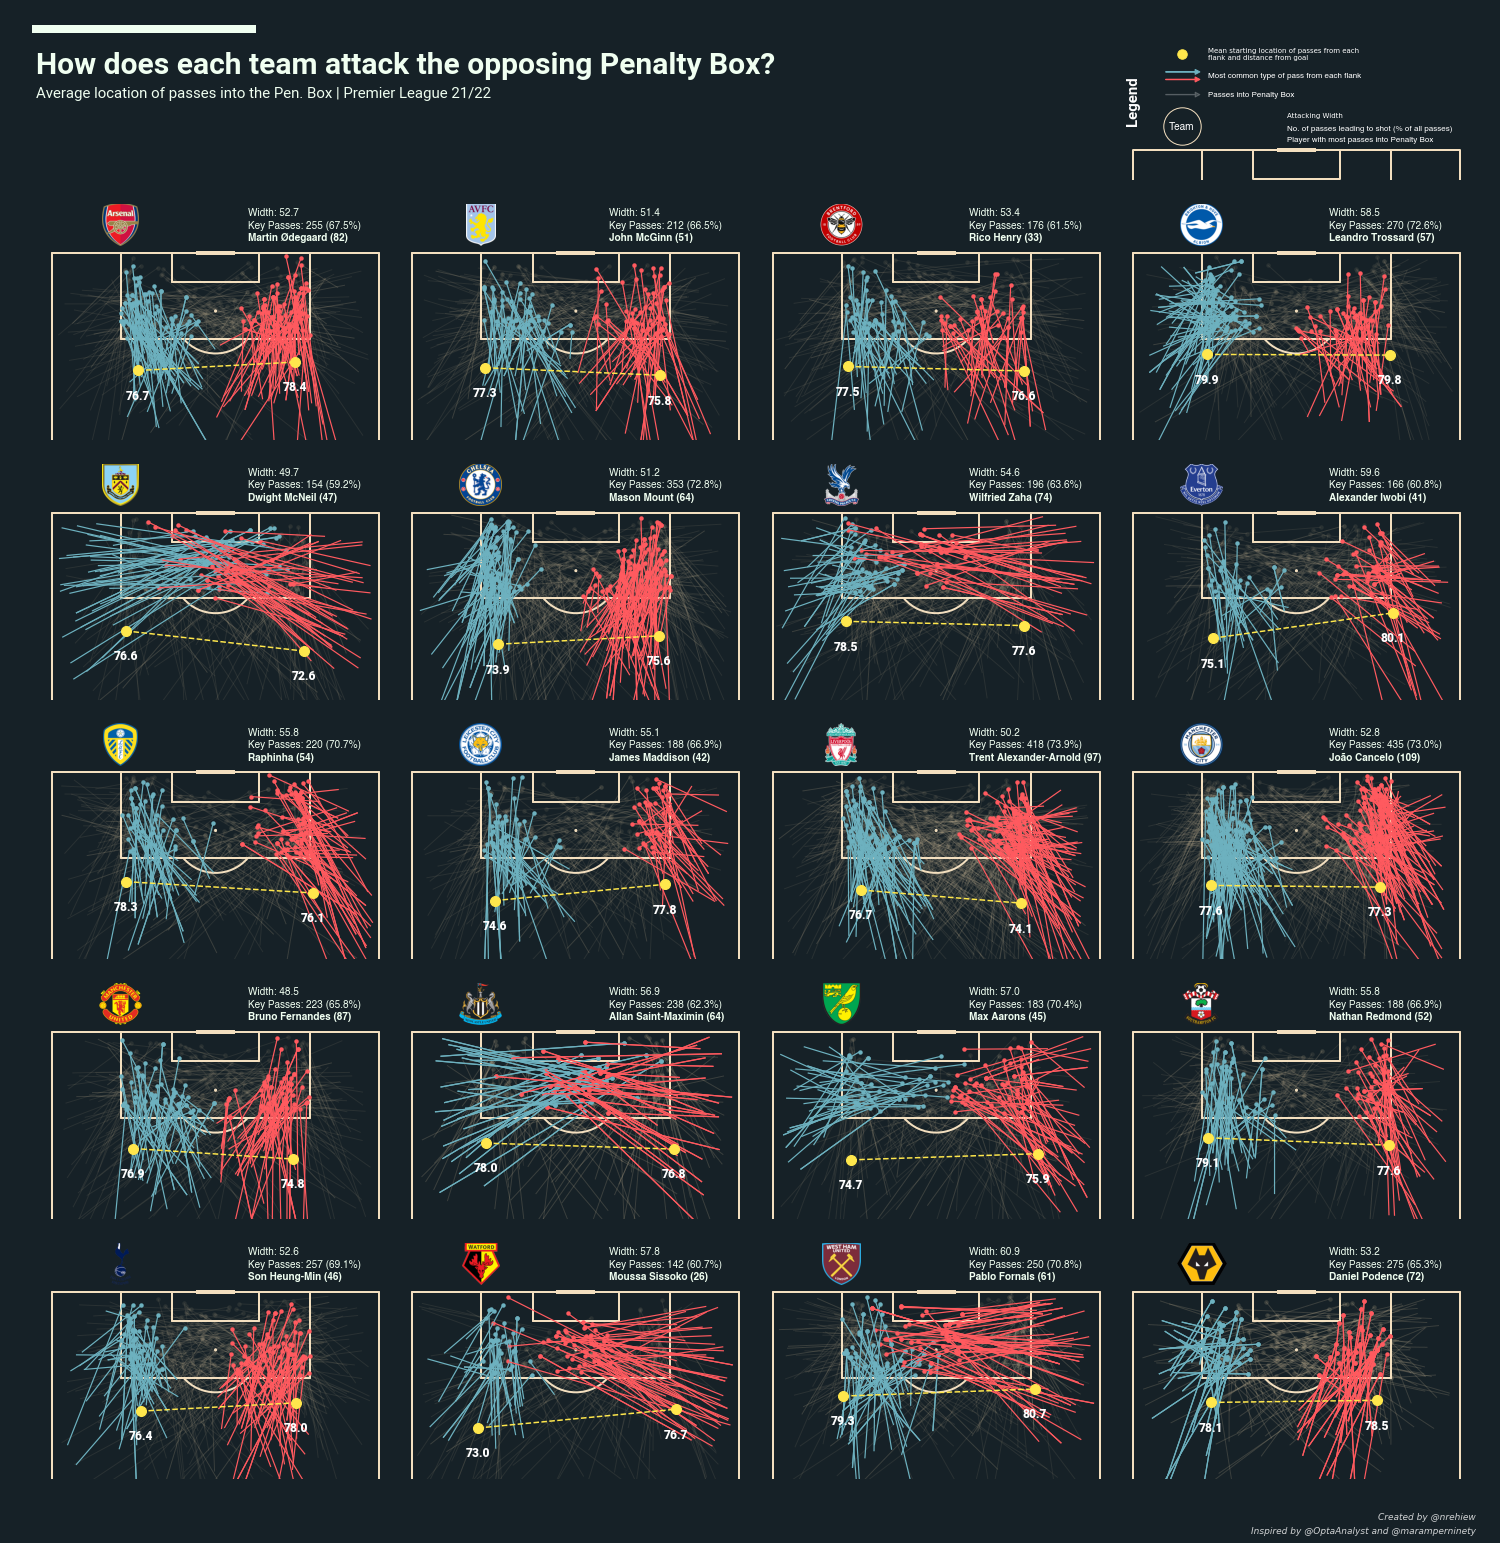

In [72]:

bg_color = '#162127'
pitchcolor = bg_color
linecolor='#F3DFBF'
leftcolor = '#FF5A5F'
rightcolor = '#6DB1BF'
pointcolor = '#FFE74C'
edgecolor = pointcolor
titlefont = 'Roboto'
font = 'Helvetica'
textcolor='#F0FFF1' #title
titlesize=30
subtitlesize=15


pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20,pad_top=15,pitch_color=pitchcolor,line_color=linecolor)
fig,axs = pitch.draw(nrows=5,ncols=4,tight_layout=False, constrained_layout=True)
fig.set_size_inches(20,20)
legendax = axs.flatten()[3].inset_axes([0,0.92,1,1])
legend_ax = plot_legend(legendax,pitchcolor,linecolor,leftcolor,rightcolor,edgecolor,pointcolor,'white')
axs = axs.flatten()
logourls = get_logo(pl['team'].unique())
for no, (i,team) in enumerate(pl.groupby('team')):
    _ = plot_team(axs[no],team,pitchcolor,linecolor,leftcolor,rightcolor,edgecolor,pointcolor,logourls[no],textcolor)
fig.patch.set_facecolor(bg_color)


#title
fig.text(0,0.99,'How does each team attack the opposing Penalty Box?',fontsize=titlesize,color=textcolor,ha='left',va='center',fontweight='bold',font=titlefont)
fig.text(0,0.97,'Average location of passes into the Pen. Box | Premier League 21/22',fontsize=subtitlesize,color=textcolor,ha='left',va='center',fontweight='normal',font=titlefont)
fig.text(-0.02,0.5,' ')
fig.text(1.01,1.025,' ')
fig.text(1,-0.02,'Created by @nrehiew',ha='right',fontsize=9,alpha=0.8,color='white',fontstyle='italic')
fig.text(1,-0.03,'Inspired by @OptaAnalyst and @maramperninety',ha='right',fontsize=9,alpha=0.8,color='white',fontstyle='italic')

_ = fig.add_artist(lines.Line2D([0.0,0.15],[1.015],linewidth=8,color=textcolor))
# plt.savefig('Crosses.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)